In [1]:
import numpyro
import numpyro.distributions as dist
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
from jax import random
from numpyro import infer
import jax.numpy as jnp
import arviz as az
import random as randomm
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import get_window
from math import floor as floor

#numpyro.set_host_device_count(2) # let's use 2 cores! jk i don't have 2 cores

In [68]:
# Generate 100 sine functions with different a,b,c parameters and random noise
def sine(a,b,c,x):
    return a * jax.numpy.sin((2*np.pi*b * x) + c)

dx = 0.001
x_data = np.arange(0,10,dx)
a_list = np.linspace(0.1,10,100)
b_list = np.linspace(0.1,3,100)
c_list = np.linspace(0,5,100)

# Choose one random sine function to work with
my_a = randomm.choice(a_list)
my_b = randomm.choice(b_list)
my_c = randomm.choice(c_list)

noise = np.random.normal(-my_a,my_a,len(x_data))
y_pure = sine(my_a, my_b, my_c, x_data)

y_data = y_pure + noise 
y_err = np.array([my_a] * len(x_data)) 

FFT freq:  1.2000000000000002
b:  1.183838383838384


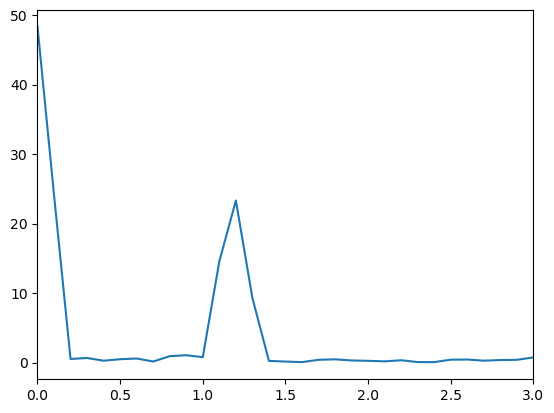

In [ ]:
# Let's do a fourier transform to find b, the frequency.
# This will make the rest of the process faster since we'll only need to find 2 parameters (a & c) instead of 3.

def fft(y):
    N = len(y)
    fs = int(1.0 / dx)
    window = get_window('hann', y.size)
    win_data = y * window
    freq = np.fft.rfftfreq(len(win_data))*fs
    freq_domain = np.fft.rfft(win_data)/fs
    return freq, abs(freq_domain)

freqs, amps = fft(y_data)
plt.plot(freqs, amps)
plt.xlim(0,3)

check_amps = []
check_freqs = []
for i in range(0,len(amps)):
    if freqs[i] > 0.1:
        check_amps.append(amps[i])
        check_freqs.append(freqs[i])

for i in range(0,len(check_amps)):
    if check_amps[i] == np.max(check_amps):
        freq = check_freqs[i]
print('FFT freq: ',freq)
print('phi: ',my_b)

In [71]:
def sine_model(x=None, y=None):
    # priors
    a = numpyro.sample('a', dist.Uniform(0.1, 10))
    b = freq
    c = numpyro.sample('c', dist.Uniform(0, 5))
    σ = numpyro.sample('σ_mg', dist.HalfNormal(scale=5))

    μ = sine(a,b,c,x)
    
    # likelihood
    obs = numpyro.sample("obs", dist.Normal(μ, σ), obs=y)

In [72]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(sine_model)
num_samples = 10000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=5000,
    num_samples=num_samples)
mcmc.run(rng_key_, x=x_data, y=y_data)
mcmc.print_summary()

/tmp/ipykernel_57115/407199250.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 15000/15000 [00:08<00:00, 1681.35it/s, 7 steps of size 7.39e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      9.06      0.19      9.06      8.74      9.38  15067.95      1.00
         c      0.88      0.02      0.88      0.85      0.92  18176.94      1.00
      σ_mg     13.69      0.10     13.69     13.53     13.85  18865.13      1.00

Number of divergences: 0


In [73]:
samples = mcmc.get_samples()

a:  9.094834 | c:  0.85898644
a:  9.240516 | c:  0.86466885
a:  9.049388 | c:  0.8621708
a:  8.928752 | c:  0.8914161
a:  8.893503 | c:  0.8737585
Actual a:  9.5 | Actual c:  1.4141414141414141


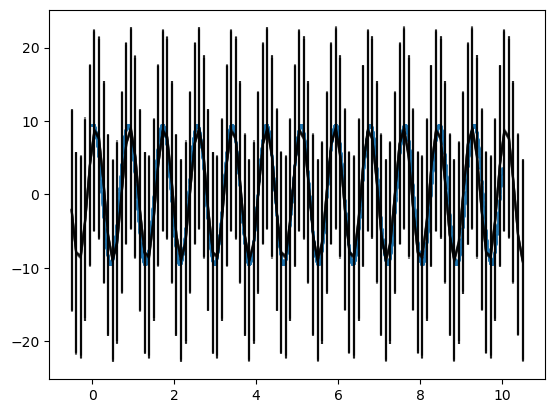

In [ ]:
plt.scatter(x_data, y_pure, s=1, alpha=0.5)

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)

# Let's look at some generated a and phi values
for i in random.choice(rng_key, num_samples, (5,)):
    mu = sine(samples['a'][i],freq,samples['c'][i],x)
    σ = samples['σ_mg'][i]
    plt.errorbar(x, mu, yerr=σ, color='k', alpha=0.5);
    print('a: ',samples['a'][i],'| phi: ',samples['c'][i])

print('Actual a: ',my_a,'| Actual phi: ',my_c)

obs
a:  9.156615 | c:  0.91433096
Actual a:  9.5 | Actual c:  1.4141414141414141
Acc a: 96.38542 | Acc b: 98.63481228668941 | Acc c: 64.656265


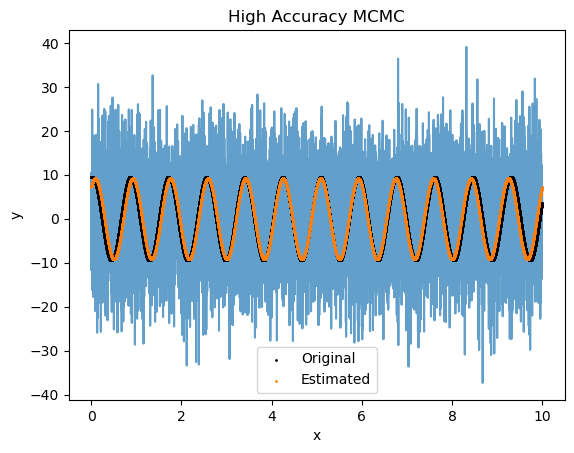

In [75]:
# Bring an angle in radians into the range (0, 2pi)
# This just makes it easier to interpret the phi parameter
def convert_angle(angle):
    return angle - 2 * np.pi * floor(angle / (2 * np.pi))

post_pred_samples = infer.Predictive(sine_model, samples)(
    random.PRNGKey(1), x=x_data,
)

for key in post_pred_samples.keys():
    print(key)

post_pred_y = post_pred_samples['obs']

plt.plot(x_data, noise+my_a, alpha=0.7, c='#1f77b4', zorder=0)
plt.scatter(x_data, y_pure, s=1, alpha=1, label='Original', c='black')
line_label = 'posterior predictive model'
scatter_label = 'posterior predictive data'

for i in random.choice(rng_key, len(post_pred_y), (1,)):
    line_label = scatter_label = None
    pred_a = samples['a'][i]
    pred_c = convert_angle(samples['c'][i])
    print('a: ',pred_a,'| c: ',pred_c)
    plt.scatter(x_data, sine(pred_a,freq,pred_c,x_data), label='Estimated', s=1, c='#ff7f0e')

plt.xlabel('x')
plt.ylabel('y')
plt.title('High Accuracy MCMC')
plt.legend();
print('Actual a: ',my_a,'| Actual c: ',my_c)

acc_a = 100 - abs(my_a - pred_a) / my_a * 100
acc_b = 100 - abs(my_b - freq) / my_b * 100
acc_c = 100 - abs(my_c - pred_c) / my_c * 100

print('Acc a:',acc_a,'| Acc b:',acc_b,'| Acc c:',acc_c)